In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
from sklearn.dummy import DummyClassifier

In [2]:
df = pd.read_csv('carnival_visitors.csv')
df.head()

,householdID,est_inc_USD,est_netw_USD,hhold_field,hhold_oldest,hhold_pax,hhold_youngest,homeState,hhold_car,stream_subs,primary
0,1,113831,418044,Finance,45,4,12,Maine,LuxurySedan,5,consume
1,2,66441,454233,Tech,44,4,11,Maine,LuxurySedan,1,entertain
2,3,160024,602594,Finance,38,2,6,Vermont,LuxurySedan,2,consume
3,4,82985,473262,Govt,39,3,8,Massachusetts,LuxurySedan,4,entertain
4,5,109369,527138,Finance,43,5,5,Massachusetts,SUV,3,consume


### Data Exploration and preprocessing

In [3]:
# dropping householdID
df2 = df.drop(['householdID'], axis=1)
df2.head()

,est_inc_USD,est_netw_USD,hhold_field,hhold_oldest,hhold_pax,hhold_youngest,homeState,hhold_car,stream_subs,primary
0,113831,418044,Finance,45,4,12,Maine,LuxurySedan,5,consume
1,66441,454233,Tech,44,4,11,Maine,LuxurySedan,1,entertain
2,160024,602594,Finance,38,2,6,Vermont,LuxurySedan,2,consume
3,82985,473262,Govt,39,3,8,Massachusetts,LuxurySedan,4,entertain
4,109369,527138,Finance,43,5,5,Massachusetts,SUV,3,consume


Dropping householdID column as it is an arbitaray number and doesn't provide any information about the household itself

In [4]:
# one hot encoding for target variable
le = LabelEncoder()
le.fit(df2['primary'])
df2['primary'] = le.transform(df2['primary'])

In [5]:
df2.head()

,est_inc_USD,est_netw_USD,hhold_field,hhold_oldest,hhold_pax,hhold_youngest,homeState,hhold_car,stream_subs,primary
0,113831,418044,Finance,45,4,12,Maine,LuxurySedan,5,0
1,66441,454233,Tech,44,4,11,Maine,LuxurySedan,1,1
2,160024,602594,Finance,38,2,6,Vermont,LuxurySedan,2,0
3,82985,473262,Govt,39,3,8,Massachusetts,LuxurySedan,4,1
4,109369,527138,Finance,43,5,5,Massachusetts,SUV,3,0


In [6]:
# 0 - consume, entertain - 1, renaming primary columnn
df2.rename(columns={'primary': 'primary_entertain'}, inplace=True)

In [7]:
# missing values 
df2.isna().sum()

est_inc_USD            0
est_netw_USD           0
hhold_field            0
hhold_oldest           0
hhold_pax              0
hhold_youngest         0
homeState              0
hhold_car            551
stream_subs            0
primary_entertain      0
dtype: int64

In [8]:
df2['hhold_car'].value_counts()

SUV               5410
LuxurySedan       3343
Sedan             2933
Pickup            1528
Compact/Hybrid    1235
Name: hhold_car, dtype: int64

In [9]:
# looking at the stats for the households with missing values 
df2.loc[(df2['hhold_car'].isna())].describe()

,est_inc_USD,est_netw_USD,hhold_oldest,hhold_pax,hhold_youngest,stream_subs,primary_entertain
count,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000
mean,93614.197822,465565.784029,45.591652,4.143376,15.762250,3.940109,0.533575
std,29212.457728,72578.294196,4.873886,1.691515,8.819179,1.829567,0.499325
min,13031.000000,278506.000000,34.000000,1.000000,3.000000,0.000000,0.000000
25%,73438.500000,422628.500000,42.000000,3.000000,12.000000,3.000000,0.000000
50%,91998.000000,467786.000000,46.000000,4.000000,14.000000,4.000000,1.000000
75%,114628.500000,512158.500000,49.000000,5.000000,17.000000,5.000000,1.000000
max,176434.000000,696933.000000,66.000000,8.000000,57.000000,9.000000,1.000000


In [10]:
df2.loc[(df2['hhold_car'].isna())]

,est_inc_USD,est_netw_USD,hhold_field,hhold_oldest,hhold_pax,hhold_youngest,homeState,hhold_car,stream_subs,primary_entertain
76,84263,472499,Services,45,2,14,Maine,NaN,3,1
105,61018,388296,Govt,42,6,15,Maine,NaN,1,1
172,75951,442529,Govt,44,4,14,Ontario,NaN,4,1
253,87813,532680,Govt,44,5,11,Rhode Island,NaN,7,1
289,144045,559091,Tech,47,4,11,New Hampshire,NaN,5,1
...,...,...,...,...,...,...,...,...,...,...
14864,69272,346539,Finance,49,5,12,Vermont,NaN,3,1
14868,38617,299875,Govt,47,3,9,Ontario,NaN,4,1
14923,55635,303474,Govt,49,6,11,New York,NaN,5,0
14938,71431,473454,Govt,40,1,40,Vermont,NaN,2,0


After looking through the rows with missing hhold_car values, we speculate that these households either don't own any vehicles (like households with 1 person/ located in the city with good public transit) or own multiple vehicles (for the bigger families) and didn't want to list a single vehicle.

Hence, we are relabeeling the NaNs to Non/Multi

In [11]:
df2['hhold_car'].fillna('None/Multi', inplace=True)
df2['hhold_car'].value_counts()

SUV               5410
LuxurySedan       3343
Sedan             2933
Pickup            1528
Compact/Hybrid    1235
None/Multi         551
Name: hhold_car, dtype: int64

In [12]:
# no. of unique values in each column
for col in df2.columns:
    print (col, len (df2[col].unique()))

est_inc_USD 13954
est_netw_USD 14569
hhold_field 7
hhold_oldest 41
hhold_pax 12
hhold_youngest 59
homeState 11
hhold_car 6
stream_subs 12
primary_entertain 2


In [13]:
df2['primary_entertain'].value_counts(normalize=True)

1    0.509467
0    0.490533
Name: primary_entertain, dtype: float64

Both the outcome classes are balanced in the dataset.

### Random Forest

In [14]:
# for columns with 3 or more unique values, I am using get_dummies without dropping any levels
categorical_cols = ['hhold_field', 'homeState', 'hhold_car']

df3 = pd.get_dummies(df2, drop_first=False, columns= categorical_cols)
df3.head()

,est_inc_USD,est_netw_USD,hhold_oldest,hhold_pax,hhold_youngest,stream_subs,primary_entertain,hhold_field_Education,hhold_field_Finance,hhold_field_Govt,...,homeState_Quebec,homeState_Rhode Island,homeState_US_Other,homeState_Vermont,hhold_car_Compact/Hybrid,hhold_car_LuxurySedan,hhold_car_None/Multi,hhold_car_Pickup,hhold_car_SUV,hhold_car_Sedan
0,113831,418044,45,4,12,5,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,66441,454233,44,4,11,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,160024,602594,38,2,6,2,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
3,82985,473262,39,3,8,4,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,109369,527138,43,5,5,3,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


#### Data Partitioning

In [15]:
y_rf= df3['primary_entertain']
X_rf= df3.loc[:, df3.columns != 'primary_entertain']
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.4, random_state=522022)

#### Hyperparameter tuning

In [16]:
param_grid = {
    'n_estimators': [20, 30, 40, 50, 60, 70],
    'max_depth': [2, 3, 4, 6, 8],
    'max_features': [12, 14, 16, 18],
    'min_samples_leaf': [24, 26, 28, 30, 32]
}

In [17]:
# rf=RandomForestClassifier(random_state=522022)

# CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
# CV_rfc.fit(X_train_rf, y_train_rf)

# # best hyperparameters
# print(CV_rfc.best_params_)

{'max_depth': 4, 'max_features': 14, 'min_samples_leaf': 30, 'n_estimators': 50}


#### Best random forest model 

In [18]:
# building random forest with the best hyperparameters
best_rf=RandomForestClassifier(n_estimators=50, max_depth=4, max_features=14, 
                               min_samples_leaf=30, random_state=522022)
best_rf.fit(X_train_rf,y_train_rf)

RandomForestClassifier(max_depth=4, max_features=14, min_samples_leaf=30,
                       n_estimators=50, random_state=522022)

#### Feature Importance

In [19]:
feature_imp_df = pd.DataFrame(list(zip(best_rf.feature_importances_, X_train_rf)))
feature_imp_df.columns = ['feature importance', 'feature']
feature_imp_df = feature_imp_df.sort_values(by='feature importance', ascending=False)
feature_imp_df

,feature importance,feature
1,0.415407,est_netw_USD
0,0.149246,est_inc_USD
2,0.093184,hhold_oldest
3,0.091108,hhold_pax
4,0.072466,hhold_youngest
5,0.030841,stream_subs
20,0.026768,homeState_Quebec
13,0.018959,homeState_Can_Other
14,0.013666,homeState_Connecticut
22,0.010723,homeState_US_Other


#### Model Evaluation

In [20]:
def conf_mat (pred_test, y_test):
    
    # confusion matrix
    mat = confusion_matrix(y_test, pred_test)
    sns.heatmap(mat, fmt='g', square=True, annot=True, cbar=False)
    plt.xlabel("Predicted Result")
    plt.ylabel("Actual Result")
    a, b = plt.ylim() 
    a += 0.5 
    b -= 0.5 
    plt.ylim(a, b)
    plt.show()

In [21]:
def calc_performance_metrics(true_values, predictions):
    '''returns performance metrics for the predictions when compared to true labels'''
    
    TP = ((predictions == 1) & (true_values == 1)).sum()
    FP = ((predictions == 1) & (true_values == 0)).sum()
    TN = ((predictions == 0) & (true_values == 0)).sum()
    FN = ((predictions == 0) & (true_values == 1)).sum()
    
    N = true_values.shape[0]
    accuracy = (true_values == predictions).sum() / N  

    dic = {}
    dic['accuracy'] = round((TP+TN)/N, 3)
    dic['sensitivity'] = round(TP/(TP + FN), 3)
    dic['specificity'] = round(TN/(TN + FP), 3)
    dic['precision'] = round(TP/(TP + FP), 3)
    dic['balanced_acc'] = round((dic['sensitivity'] + dic['specificity'])/ 2, 3)
    
    return dic

In [24]:
# predicting test/train set values 
pred_test_rf = best_rf.predict(X_test_rf)
pred_train_rf = best_rf.predict(X_train_rf)

print(calc_performance_metrics(y_test_rf, pred_test_rf))

print (f'Training accuracy: {round(accuracy_score(y_train_rf, pred_train_rf), 3)}')
print (f'Testing accuracy: {round(accuracy_score(y_test_rf, pred_test_rf), 3)}')

{'accuracy': 0.531, 'sensitivity': 0.582, 'specificity': 0.478, 'precision': 0.537, 'balanced_acc': 0.53}
Training accuracy: 0.555
Testing accuracy: 0.531


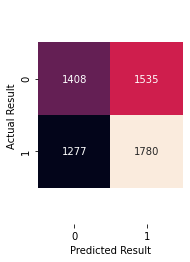

In [26]:
conf_mat (pred_test_rf, y_test_rf)

## Logistic regression

### Feature Importance

Based on the feature importances from the random forest model, variable selection can be performed for the logistic regression model.

In [131]:
feature_imp_df.head(15)

,feature importance,feature
1,0.415407,est_netw_USD
0,0.149246,est_inc_USD
2,0.093184,hhold_oldest
3,0.091108,hhold_pax
4,0.072466,hhold_youngest
5,0.030841,stream_subs
20,0.026768,homeState_Quebec
13,0.018959,homeState_Can_Other
14,0.013666,homeState_Connecticut
22,0.010723,homeState_US_Other


In [132]:
top_vars = ['est_netw_USD', 'hhold_oldest', 'est_inc_USD', 'hhold_car',
       'hhold_pax', 'stream_subs', 'homeState', 'hhold_youngest']

df4 = df2[top_vars + ['primary_entertain']]

In [133]:
df4

,est_netw_USD,hhold_oldest,est_inc_USD,hhold_car,hhold_pax,stream_subs,homeState,hhold_youngest,primary_entertain
0,418044,45,113831,LuxurySedan,4,5,Maine,12,0
1,454233,44,66441,LuxurySedan,4,1,Maine,11,1
2,602594,38,160024,LuxurySedan,2,2,Vermont,6,0
3,473262,39,82985,LuxurySedan,3,4,Massachusetts,8,1
4,527138,43,109369,SUV,5,3,Massachusetts,5,0
...,...,...,...,...,...,...,...,...,...
14995,443222,48,136586,SUV,3,1,Maine,11,0
14996,540067,42,113057,Pickup,2,1,New York,16,0
14997,507584,48,103937,Sedan,6,4,Ontario,10,0
14998,528343,38,137577,Compact/Hybrid,3,1,Vermont,12,1


In [134]:
# dummifying categorical variables, dropping one level
df4 = pd.get_dummies(df4, drop_first=True, columns=['homeState', 'hhold_car'])
df4

,est_netw_USD,hhold_oldest,est_inc_USD,hhold_pax,stream_subs,hhold_youngest,primary_entertain,homeState_Connecticut,homeState_Maine,homeState_Massachusetts,...,homeState_Ontario,homeState_Quebec,homeState_Rhode Island,homeState_US_Other,homeState_Vermont,hhold_car_LuxurySedan,hhold_car_None/Multi,hhold_car_Pickup,hhold_car_SUV,hhold_car_Sedan
0,418044,45,113831,4,5,12,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,454233,44,66441,4,1,11,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,602594,38,160024,2,2,6,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,473262,39,82985,3,4,8,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,527138,43,109369,5,3,5,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,443222,48,136586,3,1,11,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
14996,540067,42,113057,2,1,16,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14997,507584,48,103937,6,4,10,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
14998,528343,38,137577,3,1,12,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


<AxesSubplot:>

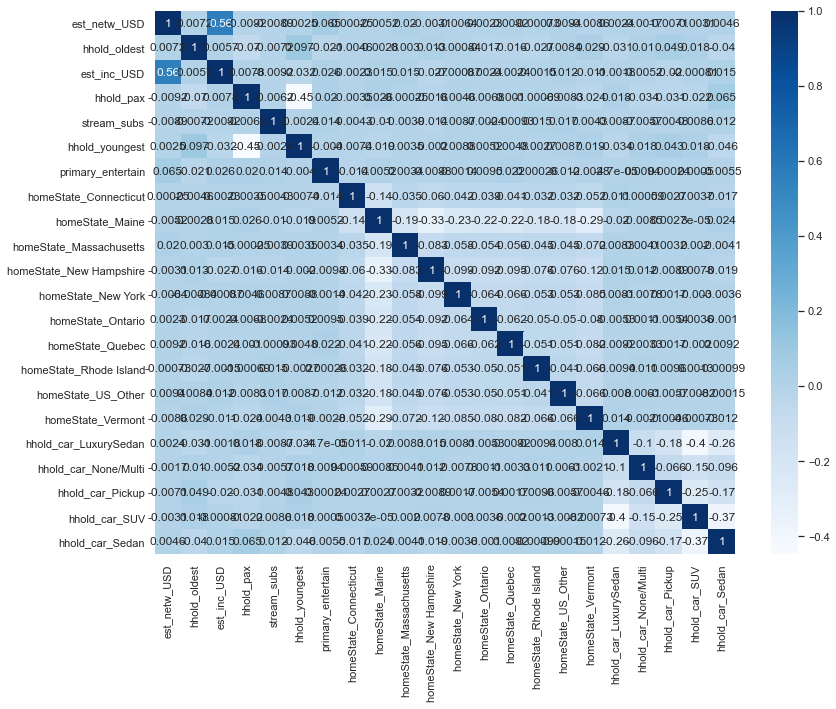

In [135]:
corr = df4.corr()

sns.set(rc={'figure.figsize':(13,10)})
sns.heatmap(corr, cmap="Blues", annot=True)

None of the variables are highly correlated to be dropped.

#### Data Partitioning

In [136]:
y_lr = df4['primary_entertain']
X_lr = df4.loc[:, df4.columns != 'primary_entertain']
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.4, random_state=520222)

In [149]:
# fiting the standardization tool on X train and applying it on Xtrain and Xtest
num_cols = ['est_netw_USD', 'hhold_oldest', 'est_inc_USD', 
       'hhold_pax', 'stream_subs', 'hhold_youngest']

scaler = StandardScaler()
scaler.fit(X_train_lr[num_cols])
X_train_lr[num_cols] = scaler.transform(X_train_lr[num_cols])
X_test_lr[num_cols] = scaler.transform(X_test_lr[num_cols])

<ipython-input-149-67d5e464a39f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_lr[num_cols] = scaler.transform(X_train_lr[num_cols])
/Users/jayalakshmijain/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-149-67d5e464a39f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [152]:
X_test_lr

,est_netw_USD,hhold_oldest,est_inc_USD,hhold_pax,stream_subs,hhold_youngest,homeState_Connecticut,homeState_Maine,homeState_Massachusetts,homeState_New Hampshire,...,homeState_Ontario,homeState_Quebec,homeState_Rhode Island,homeState_US_Other,homeState_Vermont,hhold_car_LuxurySedan,hhold_car_None/Multi,hhold_car_Pickup,hhold_car_SUV,hhold_car_Sedan
6583,-0.649978,0.340019,-0.995537,0.297340,-0.567535,-0.233095,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1110,-1.779537,0.137546,-0.736319,-0.259825,0.006699,-1.543214,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5371,-0.490178,-1.077288,-1.094045,-0.259825,0.006699,0.005108,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
5543,1.343879,-1.077288,0.763674,-0.816989,1.155169,0.838820,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5611,0.719542,-0.064926,0.556938,1.411670,-1.141770,-0.947705,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,-0.588695,-0.672343,-0.359115,-0.259825,0.580934,-0.828604,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3387,0.840361,-0.874816,0.571251,0.297340,-0.567535,-0.709502,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
10857,-0.769556,-0.672343,-0.579985,2.525999,0.006699,0.481515,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
6604,0.218292,-0.064926,0.668611,-0.259825,0.006699,-0.233095,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [153]:
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(X_train_lr, y_train_lr)

LogisticRegression(max_iter=1000)

#### Coefficients

In [154]:
df = pd.DataFrame(data=logmodel.coef_.transpose(),index=X_train_lr.columns,columns=['Coef'])
df

,Coef
est_netw_USD,0.143955
hhold_oldest,-0.027375
est_inc_USD,-0.030331
hhold_pax,0.066475
stream_subs,0.044503
hhold_youngest,0.030030
homeState_Connecticut,0.116481
homeState_Maine,0.441492
homeState_Massachusetts,0.401143
homeState_New Hampshire,0.412605


#### Model Evaluation

In [155]:
# predicting test/train set values 
pred_test_lr = logmodel.predict(X_test_lr)
pred_train_lr = logmodel.predict(X_train_lr)

print (calc_performance_metrics(y_test_lr, pred_test_lr))

print (f'Training accuracy: {round(accuracy_score(y_train_lr, pred_train_lr), 3)}')
print (f'Testing accuracy: {round(accuracy_score(y_test_lr, pred_test_lr), 3)}')

{'accuracy': 0.538, 'sensitivity': 0.611, 'specificity': 0.46, 'precision': 0.543, 'balanced_acc': 0.536}
Training accuracy: 0.537
Testing accuracy: 0.538


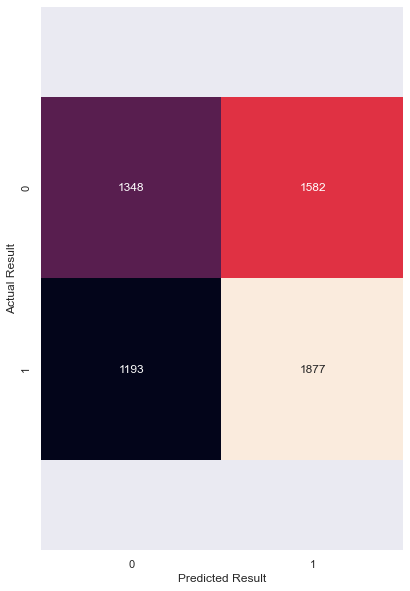

In [156]:
conf_mat (pred_test_lr, y_test_lr)

Model just 

In [157]:
logmodel.predict_proba(X_train_lr)

array([[0.47878524, 0.52121476],
       [0.49940578, 0.50059422],
       [0.43270601, 0.56729399],
       ...,
       [0.44259281, 0.55740719],
       [0.49624892, 0.50375108],
       [0.49522577, 0.50477423]])

### Comparing both models with Naive model

Random Forest
Logistic Regression
Dummy Classifier


/Users/jayalakshmijain/opt/anaconda3/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


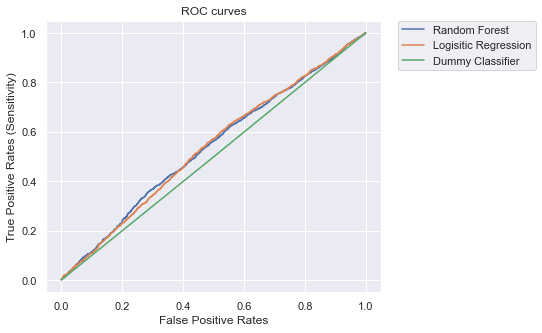

In [158]:
plt.figure(figsize=(6,5))
print ("Random Forest")
probs = best_rf.predict_proba(X_test_rf)
fpr, tpr, threshold = roc_curve(y_test_rf, probs[:,1])
class_pred = best_rf.predict(X_test_rf)
plt.plot(fpr, tpr,label = 'Random Forest');

print ("Logistic Regression")
probs = logmodel.predict_proba(X_test_lr)
fpr, tpr, threshold = roc_curve(y_test_lr, probs[:,1])
class_pred = logmodel.predict(X_test_lr)
plt.plot(fpr, tpr,label = 'Logisitic Regression');


clf = DummyClassifier(random_state=4444)
print ("Dummy Classifier")
clf.fit(X_train_rf, y_train_rf)
probs = clf.predict_proba(X_test_rf)
fpr, tpr, threshold = roc_curve(y_test_rf, probs[:,1])
class_pred = clf.predict(X_test_rf)
plt.plot(fpr, tpr,label = 'Dummy Classifier');

plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates (Sensitivity)")
plt.title("ROC curves")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

**CLASSIFICATION**

The goal of the classification model was to predict whether a particular household’s primary goal for attending
a music festival will be ‘consume’ or ‘entertain.’

We initially built a Random Forest model. We picked this model since it is robust to outliers, multicollinearity, and non-linearity. Random forest builds multiple tree models and each tree just sees a subset of all available features. The models train accuracy was 55% and test accuracy was 53%.

We also created a Logistic Regression model with the 15 most important features from the random forest. An LR model tells us how a variation in the input will after the log(odds) of obtaining a certain outcome. The accuracy for the train set was 50.8% and for the test set was 51.2%.

As we can see, the current performance of the model is as good as flipping a coin. The models have failed to capture any meaningful relationship between the variables and the outcome. This could mean that the data we have is irrelevant to this task. The data itself is not bad, but we cannot use it to predict an outcome. We could tweak the survey sent out to the households and ask different question . We could use the Likert/binary scale to ask questions such as the following:
* Do you like to go to concerts
* How often do you go to concerts often
* Do you enjoy eating out at restaurants
* How often do you eat out at restaurants

Other relevant questions include “are there any activities other than the music that you enjoy at music festivals” and giving them options to pick from (like shows, shopping, eating or comedy shows).

The potential benefits of the model, if it were to give us a higher accuracy would be as follows:
* Targeting promotional material and sending coupons for activities the households would find appealing.
* The LR coefficients could tell us exactly how each individual variable affects the customer’s goals and the chances of it happening. For example, if a household owns a SUV, it increasing the chance of them coming to Lobster Land to 'consume'.
* From the LR model, the probability of the different outcomes can be obtained. Households that are on the fence about either goal could be convinced to look forward to one or both ‘entertain’ and ‘consume’. Resources can be invested to encourage these people to engage in those goals.
* If we find out that more households are interested in a particular goal, Lobster Land can focus on expanding that for future events
* Conversely, if we see a relationship between the variables and outcome, for example households with kids prefer to visit LobsterLand for 'entertainment', then Lobster Land management can use this info for curating more kid friendly lineups in the future .
